# 모듈 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

# Linear Regression : Only Distance

## 3km

In [35]:
file_path = "D:\gait_dataset/salted/3km/train/*"
_, _, stride_length = get_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)

In [36]:
train = pd.DataFrame(inputs_pst)
train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']
train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.397719,0.323934,0.664604
1,0.499410,0.248038,0.668408
2,0.471108,0.203651,0.639809
3,0.528626,0.225862,0.680234
4,0.591989,0.192078,0.697412
...,...,...,...
985,0.411065,0.279778,0.243216
986,0.375520,0.213100,0.322103
987,0.353961,0.281699,0.263572
988,0.434953,0.267184,0.356004


In [37]:
x_train, x_test, y_train, y_test = train_test_split(train, stride_length, train_size=0.8, test_size=0.2)

In [38]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [39]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.5844059211969178

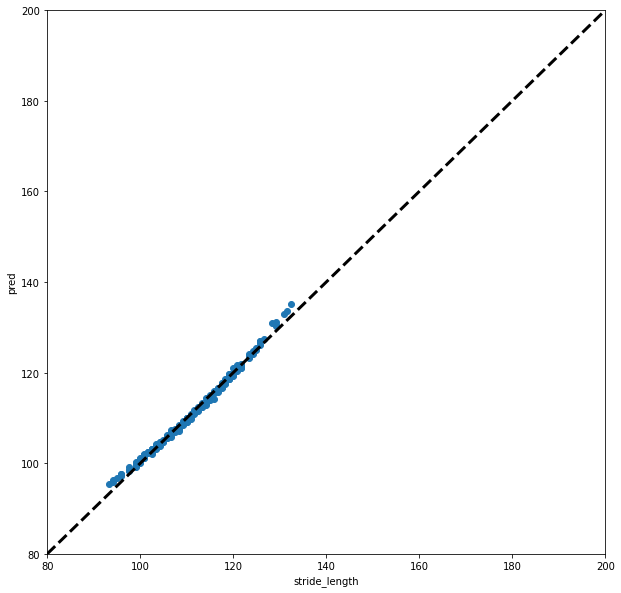

In [40]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 4km

In [29]:
file_path = "D:\gait_dataset/salted/4km/train/*"
_, _, stride_length = get_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)

In [30]:
train = pd.DataFrame(inputs_pst)
train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']
train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.393453,0.192356,0.861344
1,0.284375,0.346313,0.817588
2,0.333825,0.417524,0.845030
3,0.335323,0.244715,0.847561
4,0.333282,0.366755,0.817427
...,...,...,...
1107,0.457973,0.386141,0.371350
1108,0.170745,0.303781,0.246691
1109,0.430713,0.341889,0.423788
1110,0.390376,0.453114,0.343258


In [31]:
x_train, x_test, y_train, y_test = train_test_split(train, stride_length, train_size=0.8, test_size=0.2)

In [32]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [33]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.5797387056100292

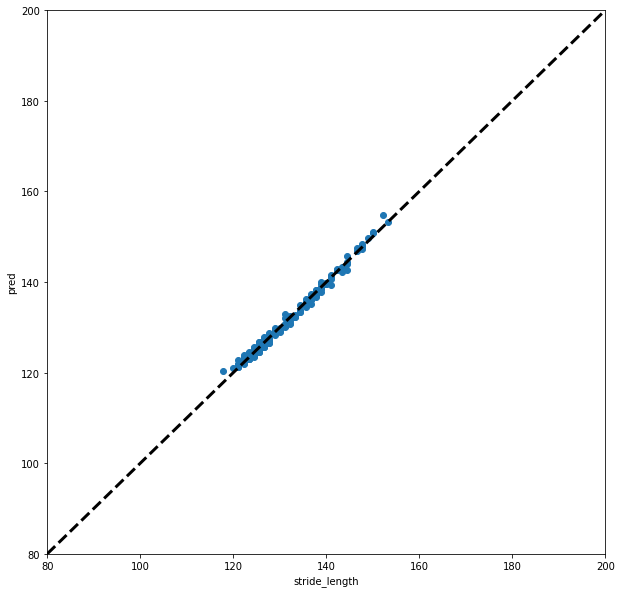

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 5km

In [22]:
file_path = "D:\gait_dataset/salted/5km/train/*"
_, _, stride_length = get_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)

In [23]:
train = pd.DataFrame(inputs_pst)
train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']
train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.324810,0.190922,0.938923
1,0.335255,0.146954,0.958002
2,0.270071,0.171294,0.963618
3,0.286354,0.244640,0.930589
4,0.317860,0.204815,0.930688
...,...,...,...
1246,0.250343,0.138564,0.129852
1247,0.280819,0.249914,0.237050
1248,0.364254,0.448751,0.161972
1249,0.154579,0.024500,0.253236


In [24]:
x_train, x_test, y_train, y_test = train_test_split(train, stride_length, train_size=0.8, test_size=0.2)

In [25]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [19]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.5034448603957058

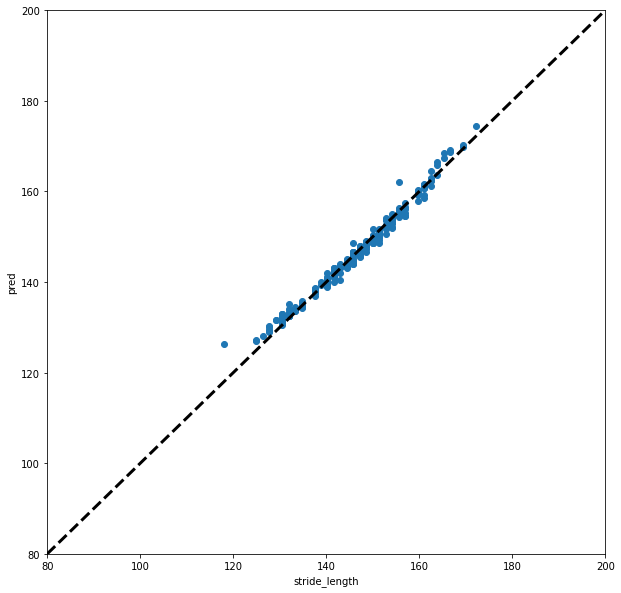

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 최종 노드 1개

## 3km

### 데이터 불러오기

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/3km/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [42]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1
- Epoch 387, Valid Loss 8.835845, MAE 2.188223

In [43]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [44]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [45]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_1_best_ks30_spd30.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 10948.320661, Valid Loss 3894.954834, MAE 61.835922
Epoch : 2/2000, Train Loss : 1752.409616, Valid Loss 1593.892639, MAE 39.102203
Epoch : 3/2000, Train Loss : 998.690600, Valid Loss 861.416962, MAE 28.176367
Best Valid Loss 861.4170
Epoch : 4/2000, Train Loss : 504.548680, Valid Loss 596.637482, MAE 23.136744
Best Valid Loss 596.6375
Epoch : 5/2000, Train Loss : 290.569328, Valid Loss 275.088943, MAE 14.850474
Best Valid Loss 275.0889
Epoch : 6/2000, Train Loss : 164.870752, Valid Loss 117.098587, MAE 8.088508
Best Valid Loss 117.0986
Epoch : 7/2000, Train Loss : 100.438996, Valid Loss 58.348577, MAE 6.007424
Best Valid Loss 58.3486
Epoch : 8/2000, Train Loss : 78.369510, Valid Loss 72.086609, MAE 7.552282
Epoch : 9/2000, Train Loss : 76.104886, Valid Loss 67.039736, MAE 5.849271
Epoch : 10/2000, Train Loss : 62.086375, Valid Loss 55.054277, MAE 6.015601
Best Valid Loss 55.0543
Epoch : 11/2000, Train Loss : 57.766728, Valid Loss 55.789047, MAE 6.405061
Ep

Epoch : 97/2000, Train Loss : 19.426346, Valid Loss 22.969666, MAE 3.447671
Best Valid Loss 22.9697
Epoch : 98/2000, Train Loss : 19.103867, Valid Loss 29.139758, MAE 4.356112
Epoch : 99/2000, Train Loss : 19.759535, Valid Loss 28.839828, MAE 4.298943
Epoch : 100/2000, Train Loss : 18.942845, Valid Loss 38.374159, MAE 5.326592
Epoch : 101/2000, Train Loss : 23.282654, Valid Loss 22.940904, MAE 3.399419
Best Valid Loss 22.9409
Epoch : 102/2000, Train Loss : 19.508280, Valid Loss 23.401052, MAE 3.588362
Epoch : 103/2000, Train Loss : 17.152320, Valid Loss 23.210011, MAE 3.574805
Epoch : 104/2000, Train Loss : 20.867611, Valid Loss 21.554009, MAE 3.273133
Best Valid Loss 21.5540
Epoch : 105/2000, Train Loss : 18.074332, Valid Loss 21.420770, MAE 3.290134
Best Valid Loss 21.4208
Epoch : 106/2000, Train Loss : 18.582763, Valid Loss 23.916728, MAE 3.489947
Epoch : 107/2000, Train Loss : 19.852545, Valid Loss 22.528992, MAE 3.515896
Epoch : 108/2000, Train Loss : 17.434535, Valid Loss 31.5534

Epoch : 199/2000, Train Loss : 13.742078, Valid Loss 13.358029, MAE 2.554615
Best Valid Loss 13.3580
Epoch : 200/2000, Train Loss : 13.807391, Valid Loss 25.350618, MAE 3.959852
Epoch : 201/2000, Train Loss : 19.748879, Valid Loss 13.167747, MAE 2.565084
Best Valid Loss 13.1677
Epoch : 202/2000, Train Loss : 10.248772, Valid Loss 21.825712, MAE 3.852939
Epoch : 203/2000, Train Loss : 11.425423, Valid Loss 13.129930, MAE 2.537590
Best Valid Loss 13.1299
Epoch : 204/2000, Train Loss : 9.278913, Valid Loss 13.467750, MAE 2.573429
Epoch : 205/2000, Train Loss : 11.249997, Valid Loss 13.097574, MAE 2.533608
Best Valid Loss 13.0976
Epoch : 206/2000, Train Loss : 9.488643, Valid Loss 13.140602, MAE 2.572690
Epoch : 207/2000, Train Loss : 9.203410, Valid Loss 13.248917, MAE 2.555483
Epoch : 208/2000, Train Loss : 9.575844, Valid Loss 16.421969, MAE 2.958474
Epoch : 209/2000, Train Loss : 13.510534, Valid Loss 24.314444, MAE 3.897506
Epoch : 210/2000, Train Loss : 16.233733, Valid Loss 22.75701

Epoch : 301/2000, Train Loss : 20.709144, Valid Loss 15.064474, MAE 2.974479
Epoch : 302/2000, Train Loss : 13.590372, Valid Loss 28.793364, MAE 4.736079
Epoch : 303/2000, Train Loss : 16.411250, Valid Loss 15.440321, MAE 3.111063
Epoch : 304/2000, Train Loss : 17.875909, Valid Loss 10.687734, MAE 2.327577
Epoch : 305/2000, Train Loss : 14.804834, Valid Loss 16.912197, MAE 3.208266
Epoch : 306/2000, Train Loss : 12.971712, Valid Loss 14.331201, MAE 2.944818
Epoch : 307/2000, Train Loss : 12.592051, Valid Loss 12.857852, MAE 2.711564
Epoch : 308/2000, Train Loss : 11.090474, Valid Loss 10.865542, MAE 2.386751
Epoch : 309/2000, Train Loss : 11.000470, Valid Loss 11.489938, MAE 2.478526
Epoch : 310/2000, Train Loss : 7.845372, Valid Loss 11.448569, MAE 2.507327
Epoch : 311/2000, Train Loss : 9.132223, Valid Loss 17.084190, MAE 3.275361
Epoch : 312/2000, Train Loss : 13.226074, Valid Loss 12.023659, MAE 2.595032
Epoch : 313/2000, Train Loss : 9.300589, Valid Loss 12.842434, MAE 2.735113
Ep

Epoch : 406/2000, Train Loss : 13.752048, Valid Loss 16.513135, MAE 3.339011
Epoch : 407/2000, Train Loss : 14.926257, Valid Loss 10.790395, MAE 2.383202
Epoch : 408/2000, Train Loss : 8.861441, Valid Loss 10.656956, MAE 2.476084
Early stopping
Best Result : Epoch 387, Valid Loss 8.835845, MAE 2.188223


In [46]:
### scatter plot
file_path = "D:\gait_dataset/salted/3km/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [48]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_1_best_ks30_spd30.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

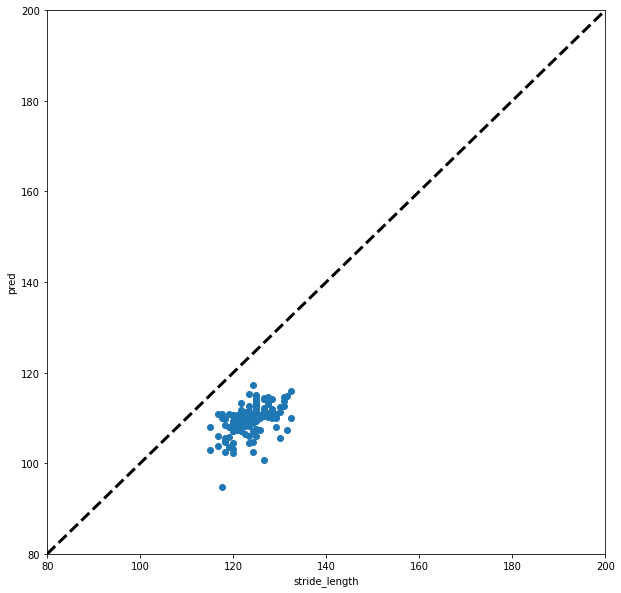

In [50]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- Conv1d의 kernel_size 조정 : 30 -> 60
- Best Result : Epoch 177, Valid Loss 18.790442, MAE 2.685503
    - 큰 영향을 주는 것 같지는 않지만 수렴이 빠름

In [19]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 60),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 60),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 60),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 60),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(5824*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [22]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [21]:
#Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_1_best_ks60.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6974.164514, Valid Loss 1220.723450, MAE 31.468950
Epoch : 2/2000, Train Loss : 752.617633, Valid Loss 443.869064, MAE 17.391273
Best Valid Loss 443.8691
Epoch : 3/2000, Train Loss : 287.896519, Valid Loss 233.136396, MAE 12.984757
Best Valid Loss 233.1364
Epoch : 4/2000, Train Loss : 239.227547, Valid Loss 244.875636, MAE 13.475310
Epoch : 5/2000, Train Loss : 233.462458, Valid Loss 227.698840, MAE 12.910347
Best Valid Loss 227.6988
Epoch : 6/2000, Train Loss : 228.753220, Valid Loss 226.976115, MAE 12.863390
Best Valid Loss 226.9761
Epoch : 7/2000, Train Loss : 226.728002, Valid Loss 224.390429, MAE 12.790303
Best Valid Loss 224.3904
Epoch : 8/2000, Train Loss : 224.725432, Valid Loss 221.544782, MAE 12.772385
Best Valid Loss 221.5448
Epoch : 9/2000, Train Loss : 223.851826, Valid Loss 218.872658, MAE 12.665787
Best Valid Loss 218.8727
Epoch : 10/2000, Train Loss : 221.347144, Valid Loss 216.946645, MAE 12.577463
Best Valid Loss 216.9466
Epoch : 11/2000, 

Epoch : 96/2000, Train Loss : 36.748939, Valid Loss 51.667736, MAE 5.168609
Epoch : 97/2000, Train Loss : 37.109599, Valid Loss 28.733579, MAE 3.584707
Epoch : 98/2000, Train Loss : 33.359232, Valid Loss 30.067620, MAE 3.467336
Epoch : 99/2000, Train Loss : 32.593034, Valid Loss 28.274392, MAE 3.327130
Epoch : 100/2000, Train Loss : 38.061912, Valid Loss 26.812831, MAE 3.193783
Best Valid Loss 26.8128
Epoch : 101/2000, Train Loss : 31.381788, Valid Loss 28.176177, MAE 3.371308
Epoch : 102/2000, Train Loss : 32.464003, Valid Loss 51.699924, MAE 5.485721
Epoch : 103/2000, Train Loss : 34.663943, Valid Loss 26.448321, MAE 3.251493
Best Valid Loss 26.4483
Epoch : 104/2000, Train Loss : 33.863060, Valid Loss 37.677169, MAE 4.433468
Epoch : 105/2000, Train Loss : 41.880779, Valid Loss 65.300717, MAE 6.333389
Epoch : 106/2000, Train Loss : 66.008823, Valid Loss 46.804860, MAE 5.276776
Epoch : 107/2000, Train Loss : 43.571939, Valid Loss 42.405494, MAE 4.896914
Epoch : 108/2000, Train Loss : 3

In [23]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [24]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_1_best_ks60.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(60,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(60,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(60,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(60,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=11648, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

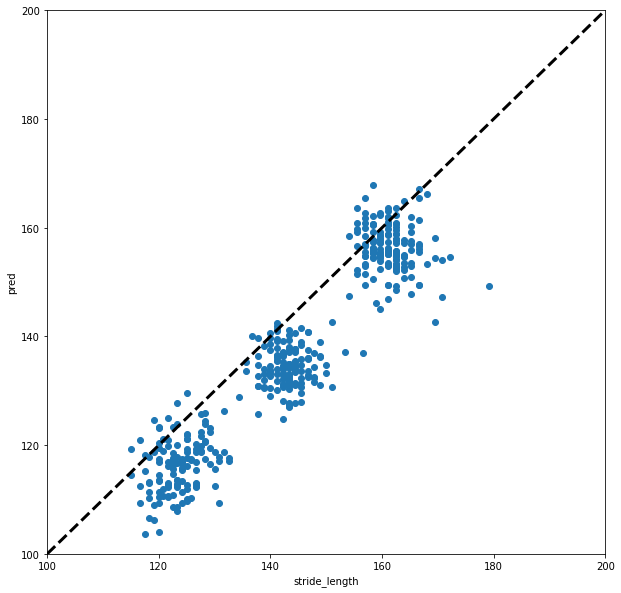

In [25]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([100, 200])
plt.xlabel('stride_length')
plt.ylim([100, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 각각 입력, 최종 노드 3개
- 최종적으로 출력된 노드 3개를 각 축별 distance와 곱

## Model & Scatter Plot
- Best Result : Epoch 259, Valid Loss 40.381912, MAE 4.223338

In [26]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [27]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [28]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)

        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_dist_best_ks30.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 7149.619652, Valid Loss 1189.682658, MAE 34.657738
Epoch : 2/2000, Train Loss : 926.689648, Valid Loss 758.439626, MAE 24.260277
Best Valid Loss 758.4396
Epoch : 3/2000, Train Loss : 571.247713, Valid Loss 646.989380, MAE 23.121986
Best Valid Loss 646.9894
Epoch : 4/2000, Train Loss : 523.347839, Valid Loss 614.578135, MAE 23.523153
Best Valid Loss 614.5781
Epoch : 5/2000, Train Loss : 496.440107, Valid Loss 615.710866, MAE 23.909782
Epoch : 6/2000, Train Loss : 484.257493, Valid Loss 595.289449, MAE 23.213823
Best Valid Loss 595.2894
Epoch : 7/2000, Train Loss : 469.962442, Valid Loss 586.671666, MAE 23.123833
Best Valid Loss 586.6717
Epoch : 8/2000, Train Loss : 455.588360, Valid Loss 574.069224, MAE 22.813021
Best Valid Loss 574.0692
Epoch : 9/2000, Train Loss : 436.112337, Valid Loss 543.728724, MAE 22.320431
Best Valid Loss 543.7287
Epoch : 10/2000, Train Loss : 415.052519, Valid Loss 522.167099, MAE 21.726231
Best Valid Loss 522.1671
Epoch : 11/2000, 

Epoch : 94/2000, Train Loss : 96.843541, Valid Loss 156.021950, MAE 10.105060
Epoch : 95/2000, Train Loss : 112.566843, Valid Loss 155.869556, MAE 8.437404
Epoch : 96/2000, Train Loss : 121.605730, Valid Loss 140.581547, MAE 9.012805
Epoch : 97/2000, Train Loss : 106.373594, Valid Loss 134.209761, MAE 8.331826
Epoch : 98/2000, Train Loss : 90.016880, Valid Loss 132.953189, MAE 8.451293
Epoch : 99/2000, Train Loss : 93.423788, Valid Loss 128.444646, MAE 8.192470
Best Valid Loss 128.4446
Epoch : 100/2000, Train Loss : 99.881033, Valid Loss 131.868801, MAE 8.421336
Epoch : 101/2000, Train Loss : 93.873319, Valid Loss 142.533735, MAE 9.471630
Epoch : 102/2000, Train Loss : 110.623926, Valid Loss 175.679654, MAE 11.712895
Epoch : 103/2000, Train Loss : 117.101210, Valid Loss 132.312791, MAE 8.587847
Epoch : 104/2000, Train Loss : 110.032742, Valid Loss 141.726926, MAE 7.715115
Epoch : 105/2000, Train Loss : 104.187491, Valid Loss 125.584393, MAE 8.098479
Best Valid Loss 125.5844
Epoch : 106

Epoch : 193/2000, Train Loss : 46.804967, Valid Loss 86.229628, MAE 7.402561
Epoch : 194/2000, Train Loss : 47.065030, Valid Loss 62.085991, MAE 5.980819
Best Valid Loss 62.0860
Epoch : 195/2000, Train Loss : 36.522270, Valid Loss 60.920818, MAE 6.035301
Best Valid Loss 60.9208
Epoch : 196/2000, Train Loss : 35.574135, Valid Loss 57.162093, MAE 5.425461
Best Valid Loss 57.1621
Epoch : 197/2000, Train Loss : 35.133240, Valid Loss 58.549232, MAE 5.269915
Epoch : 198/2000, Train Loss : 34.894101, Valid Loss 56.483390, MAE 5.520320
Best Valid Loss 56.4834
Epoch : 199/2000, Train Loss : 35.240672, Valid Loss 81.203354, MAE 7.214118
Epoch : 200/2000, Train Loss : 36.350185, Valid Loss 55.176113, MAE 5.443563
Best Valid Loss 55.1761
Epoch : 201/2000, Train Loss : 33.322231, Valid Loss 55.622069, MAE 5.666264
Epoch : 202/2000, Train Loss : 33.959995, Valid Loss 66.440168, MAE 6.489676
Epoch : 203/2000, Train Loss : 41.729085, Valid Loss 59.294913, MAE 5.746737
Epoch : 204/2000, Train Loss : 35

In [29]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [30]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_dist_best_ks30.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

torch.Size([431, 3])


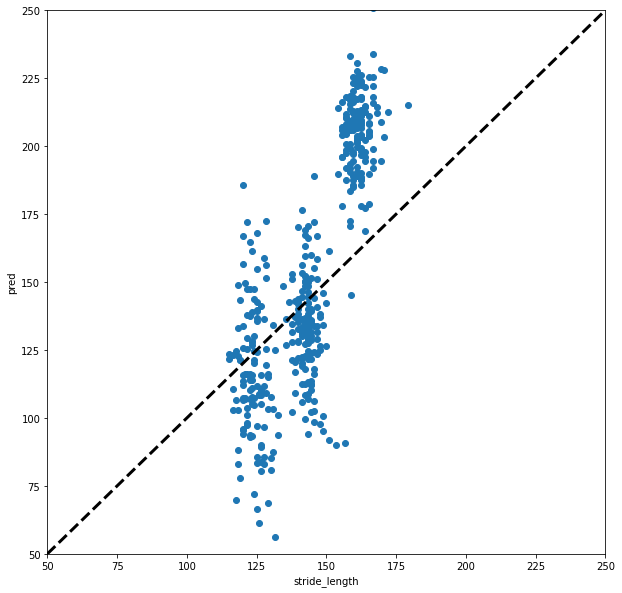

In [32]:
pred = model(inputs_acc, inputs_gyr)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 축별 입력
- 각 축 Acc에서 얻어진 축별 distance를 곱해주기 때문에 축별로 데이터를 입력
    - 축별 Acc/Gyro의 정보가 알맞은 축의 distance와 곱해져야 한다는 생각에 시도
- 3개의 인코더에는 각각 (Acc_x, Gyro_x) / (Acc_y, Gyro_y) / (Acc_z, Gyro_z)가 입력으로 들어감
    - 인코더의 각 output을 concat한 뒤 FC-Layer에 넣었을 때, 축별 정보가 순서대로 보존될 수 있을지는 의문 부호 
- Pressure는 축이 따로 없으므로 고려하지 않음

## 데이터 불러오기

In [45]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Axis_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [46]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Model & Scatter Plot
- Best Result : Epoch 194, Valid Loss 32.528639, MAE 4.294555

In [70]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_axis(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_axis, self).__init__()
             
        self.conv1d_x = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_y = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        
        self.conv1d_z = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*3, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_x, inputs_y, inputs_z): 
        conv1d_output_x = self.conv1d_x(inputs_x)
        conv1d_output_y = self.conv1d_y(inputs_y)
        conv1d_output_z = self.conv1d_z(inputs_z)
        
        enc_output = torch.concat((conv1d_output_x, conv1d_output_y, conv1d_output_z), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [71]:
input_dim = 2
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [72]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
        inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_x, inputs_y, inputs_z)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)

        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
            inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_x, inputs_y, inputs_z)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_axis_best_ks30.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6849.530436, Valid Loss 1168.314697, MAE 31.355806
Epoch : 2/2000, Train Loss : 864.669326, Valid Loss 612.329783, MAE 16.264860
Best Valid Loss 612.3298
Epoch : 3/2000, Train Loss : 589.246938, Valid Loss 526.594884, MAE 18.518312
Best Valid Loss 526.5949
Epoch : 4/2000, Train Loss : 553.286203, Valid Loss 512.176890, MAE 18.732841
Best Valid Loss 512.1769
Epoch : 5/2000, Train Loss : 548.926233, Valid Loss 526.086319, MAE 20.278049
Epoch : 6/2000, Train Loss : 511.977479, Valid Loss 473.860921, MAE 17.935377
Best Valid Loss 473.8609
Epoch : 7/2000, Train Loss : 489.095901, Valid Loss 448.458491, MAE 17.434975
Best Valid Loss 448.4585
Epoch : 8/2000, Train Loss : 473.027990, Valid Loss 432.769114, MAE 16.332811
Best Valid Loss 432.7691
Epoch : 9/2000, Train Loss : 444.482322, Valid Loss 412.248550, MAE 15.951297
Best Valid Loss 412.2486
Epoch : 10/2000, Train Loss : 414.985577, Valid Loss 397.752101, MAE 17.163071
Best Valid Loss 397.7521
Epoch : 11/2000, 

Epoch : 94/2000, Train Loss : 60.780403, Valid Loss 76.036847, MAE 7.179021
Epoch : 95/2000, Train Loss : 67.996763, Valid Loss 79.636118, MAE 7.578677
Epoch : 96/2000, Train Loss : 65.629438, Valid Loss 88.479898, MAE 7.678430
Epoch : 97/2000, Train Loss : 58.668947, Valid Loss 74.371758, MAE 7.172230
Best Valid Loss 74.3718
Epoch : 98/2000, Train Loss : 57.906890, Valid Loss 76.306203, MAE 6.679660
Epoch : 99/2000, Train Loss : 64.026802, Valid Loss 80.587857, MAE 7.149890
Epoch : 100/2000, Train Loss : 61.044780, Valid Loss 85.293031, MAE 8.288418
Epoch : 101/2000, Train Loss : 70.472009, Valid Loss 100.799805, MAE 8.421721
Epoch : 102/2000, Train Loss : 81.524724, Valid Loss 93.171730, MAE 8.748089
Epoch : 103/2000, Train Loss : 59.431019, Valid Loss 68.915815, MAE 6.823329
Best Valid Loss 68.9158
Epoch : 104/2000, Train Loss : 54.576843, Valid Loss 68.180007, MAE 6.618252
Best Valid Loss 68.1800
Epoch : 105/2000, Train Loss : 52.746727, Valid Loss 76.125436, MAE 7.439564
Epoch : 1

Epoch : 193/2000, Train Loss : 26.176221, Valid Loss 42.891813, MAE 5.180143
Epoch : 194/2000, Train Loss : 24.221730, Valid Loss 32.528639, MAE 4.294555
Best Valid Loss 32.5286
Epoch : 195/2000, Train Loss : 25.207433, Valid Loss 35.785869, MAE 4.636862
Epoch : 196/2000, Train Loss : 26.416232, Valid Loss 37.128935, MAE 4.997412
Epoch : 197/2000, Train Loss : 23.993095, Valid Loss 41.893327, MAE 4.866847
Epoch : 198/2000, Train Loss : 23.133130, Valid Loss 33.576603, MAE 4.333020
Epoch : 199/2000, Train Loss : 25.393146, Valid Loss 47.359198, MAE 5.171652
Epoch : 200/2000, Train Loss : 35.671273, Valid Loss 45.330066, MAE 5.152297
Epoch : 201/2000, Train Loss : 26.471109, Valid Loss 36.986179, MAE 4.440410
Epoch : 202/2000, Train Loss : 26.766417, Valid Loss 41.681213, MAE 4.886549
Epoch : 203/2000, Train Loss : 35.939796, Valid Loss 49.900145, MAE 5.942390
Epoch : 204/2000, Train Loss : 25.655564, Valid Loss 44.643739, MAE 5.367122
Epoch : 205/2000, Train Loss : 34.139870, Valid Loss

In [73]:
### scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = torch.Tensor(np.array(inputs_x)), torch.Tensor(np.array(inputs_y)), torch.Tensor(np.array(inputs_z)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [76]:
input_dim = 2
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_axis(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_axis_best_ks30.pth'))
model.eval()

Encoder_axis(
  (conv1d_x): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_y): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_z): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=23232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  

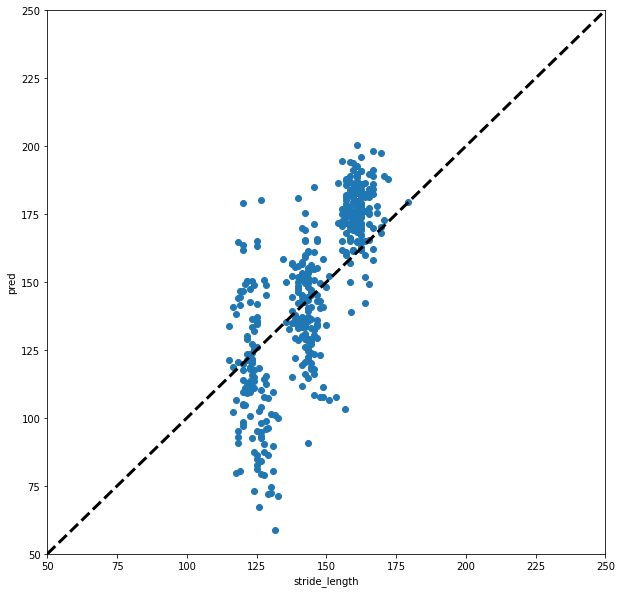

In [77]:
pred = model(inputs_x, inputs_y, inputs_z)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()